In [23]:
import sys, os
sys.path.append('../')
sys.path.append('../src/')

import torch
import numpy as np
import utils
from torch.nn import Module, Parameter
import torch.optim as opt
from utils import preprocess
import torch.nn.functional as F

import torch.optim as opt
from torch import softmax, log_softmax, Tensor
from sklearn.cluster import KMeans
from scipy.sparse.linalg import svds
import seaborn as sns

from sklearn.decomposition import PCA
from umap import UMAP

import pandas as pd 
import numpy as np 
import scipy.sparse as sp
import torch
import model 
import model_refine
import time

import quantile 

import coupleNMF as coupleNMF

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [43]:
################################################################
# Works better when we first transform scATAC-Seq to scRNA-Seq
# read in dataset
################################################################
dir = '../data/real/diag/Xichen/'

counts_rnas = []
counts_atacs = []
counts_proteins = []
for batch in [1, 2]:
    try:
        counts_atac = np.array(sp.load_npz(os.path.join(dir, 'RxC' + str(batch) + ".npz")).todense().T)
        counts_atac = utils.preprocess(counts_atac, modality = "ATAC")

    except:
        counts_atac = None
        
    try:
        counts_rna = np.array(sp.load_npz(os.path.join(dir, 'GxC' + str(batch) + ".npz")).todense().T)
        counts_rna = utils.preprocess(counts_rna, modality = "RNA")
    
    except:
        counts_rna = None
    
    # preprocess the count matrix
    counts_rnas.append(counts_rna)
    counts_atacs.append(counts_atac)


counts_rnas[1] = counts_atacs[1] @ A.T
counts_rnas[1] = counts_rnas[1]/np.max(counts_rnas[1])

counts = {"rna":counts_rnas}

interacts = None

# obtain the feature name
genes = pd.read_csv(dir + "genes.txt", header = None).values.squeeze()
regions = pd.read_csv(dir + "regions.txt", header = None).values.squeeze()

counts["feats_name"] = {"rna": genes}
counts["feats_name"] = feats_name



In [52]:
#hyper parameters: best lr = 5e-3, T = 4000, latent_dims = 13
alpha = [1000, 1, 100, 100, 0.00]
batchsize = 0.1
run = 0
Ns = [8] * 2
K = 8
N_feat = Ns[0]
interval = 100
T = 2000
lr = 1e-2

In [53]:
# didn't use the interaction matrix
model1 = model.cfrm_new(counts = counts, interacts = None, Ns = Ns, K = K, N_feat = N_feat, batch_size = batchsize, interval = interval, lr = lr, alpha = alpha, seed = run).to(device)
losses1 = model1.train_func(T = T, T1 = None)

Input sanity check...
Finished.
Epoch 100, Validating Loss: 10.3342
	 loss 1: 10.33418
	 loss 2: 0.00000
	 loss 3: 0.00000
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 200, Validating Loss: 10.3311
	 loss 1: 10.33113
	 loss 2: 0.00000
	 loss 3: 0.00000
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 300, Validating Loss: 10.3304
	 loss 1: 10.33041
	 loss 2: 0.00000
	 loss 3: 0.00000
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 400, Validating Loss: 10.3147
	 loss 1: 10.31467
	 loss 2: 0.00000
	 loss 3: 0.00000
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 500, Validating Loss: 10.2395
	 loss 1: 10.23949
	 loss 2: 0.00000
	 loss 3: 0.00000
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 600, Validating Loss: 10.1301
	 loss 1: 10.13011
	 loss 2: 0.00000
	 loss 3: 0.00000
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 700, Validating Loss: 10.0775
	 loss 1: 10.07750
	 loss 2: 0.00000
	 loss 3: 0.00000
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 800, Validating Loss: 10.0550
	 loss 1: 10.05501
	 loss 2: 0.00000
	 loss

In [54]:
# assigning cell clusters and gene clusters
model1.assign_clusters(n_relocate = None)


assigning cell clusters...
assigning feature clusters...
binarizing association matrix...


## Visualize cell embedding
Extract cell factor and perform UMAP visualization

In [55]:
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.8, random_state = 0) 
zs = []
labels = []
prec_labels = []
pre_labels = []
for batch in range(0,2):
    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
    # z = model1.C_cells[batch].cpu().detach().numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cell_type"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps = []
for batch in range(0,2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 1:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

### Ground truth labeling

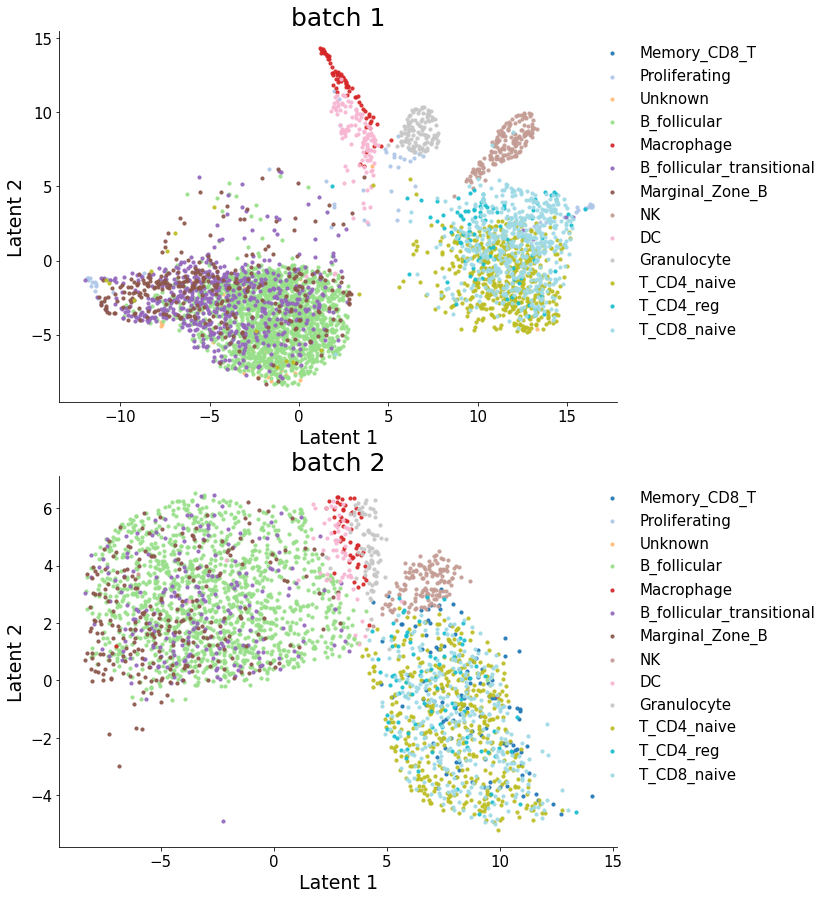

In [56]:
# utils.plot_latent_ext(x_umaps, annos = prec_labels, mode = "separate", save = None, figsize = (10,30), axis_label = "Latent")
utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, figsize = (10,15), axis_label = "Latent")


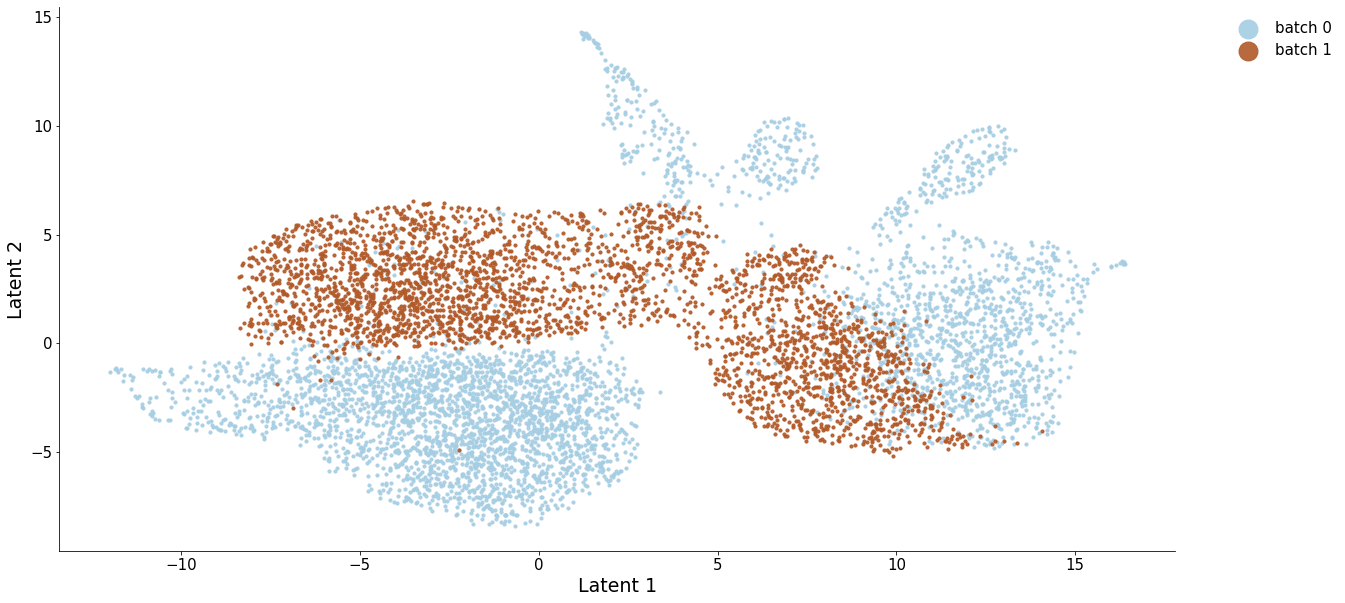

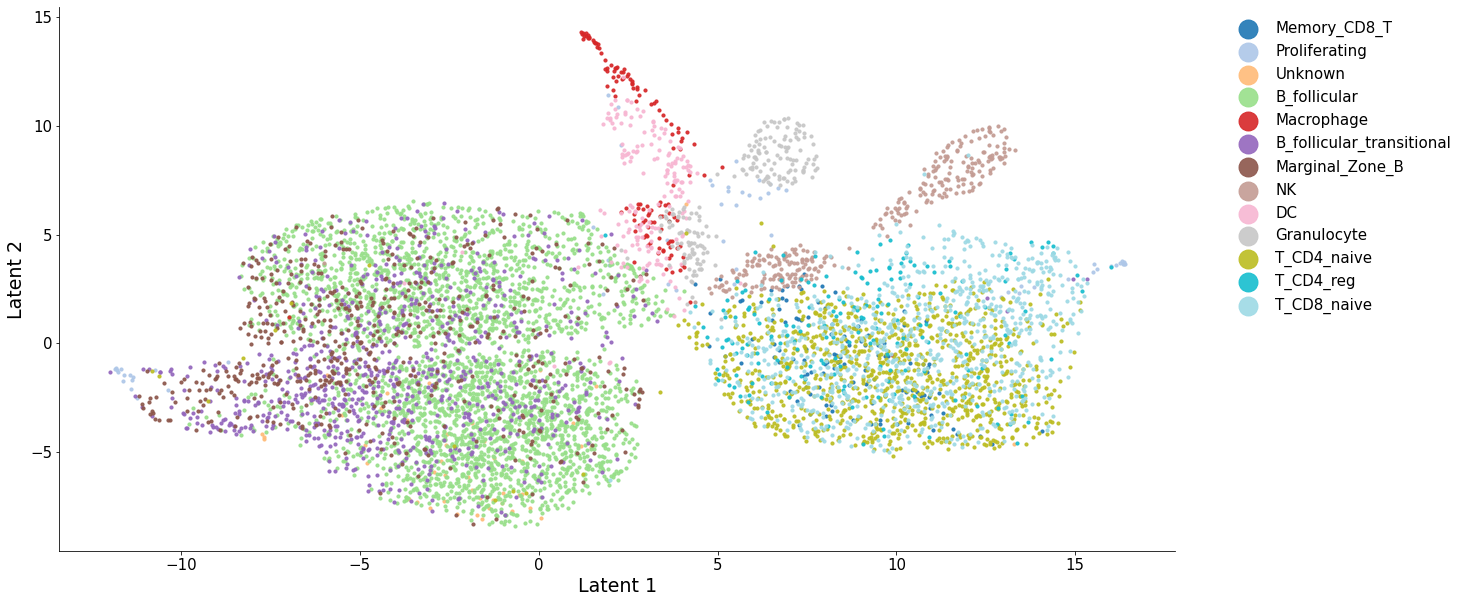

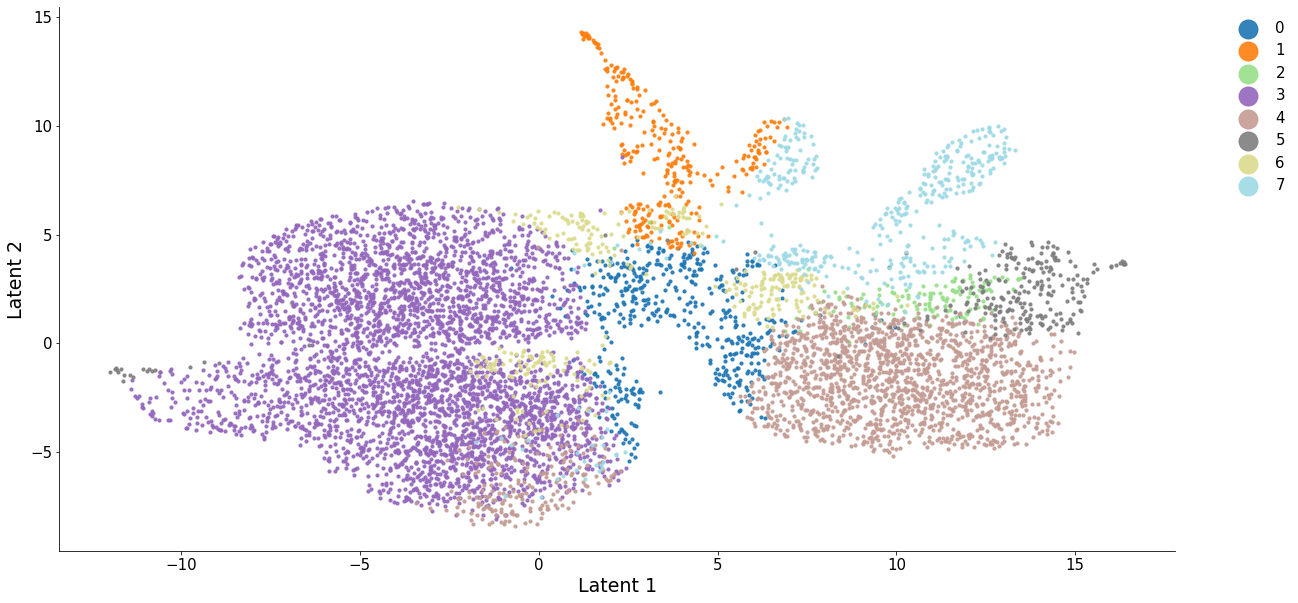

In [57]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = pre_labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)


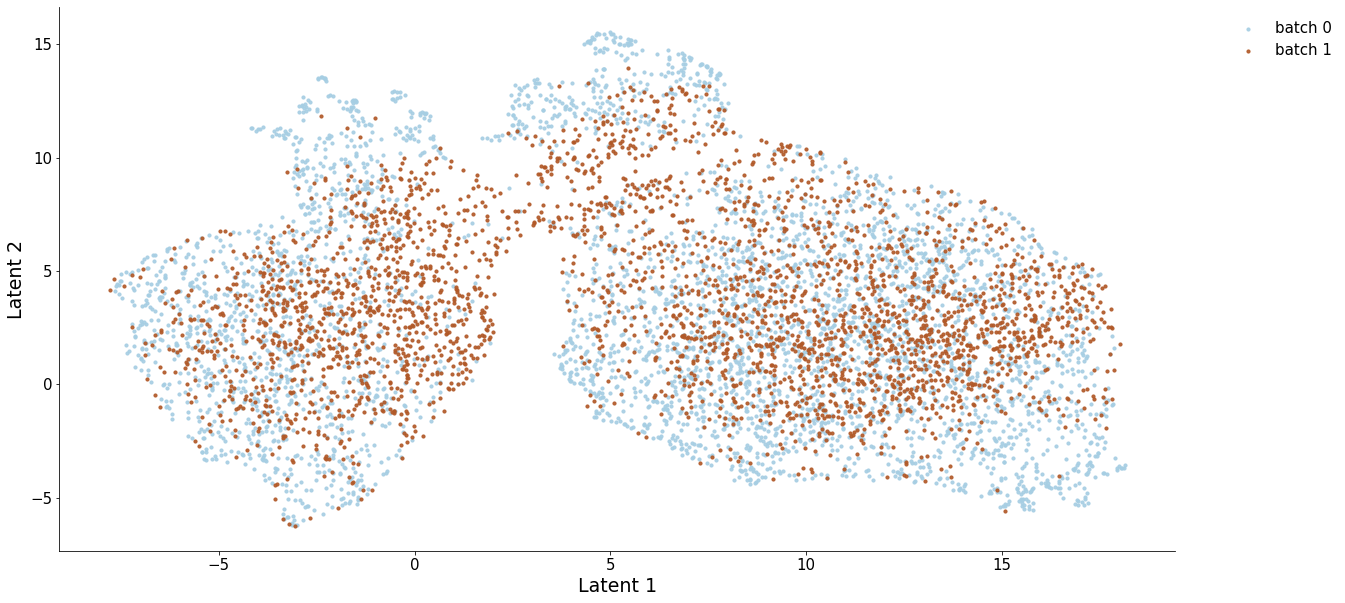

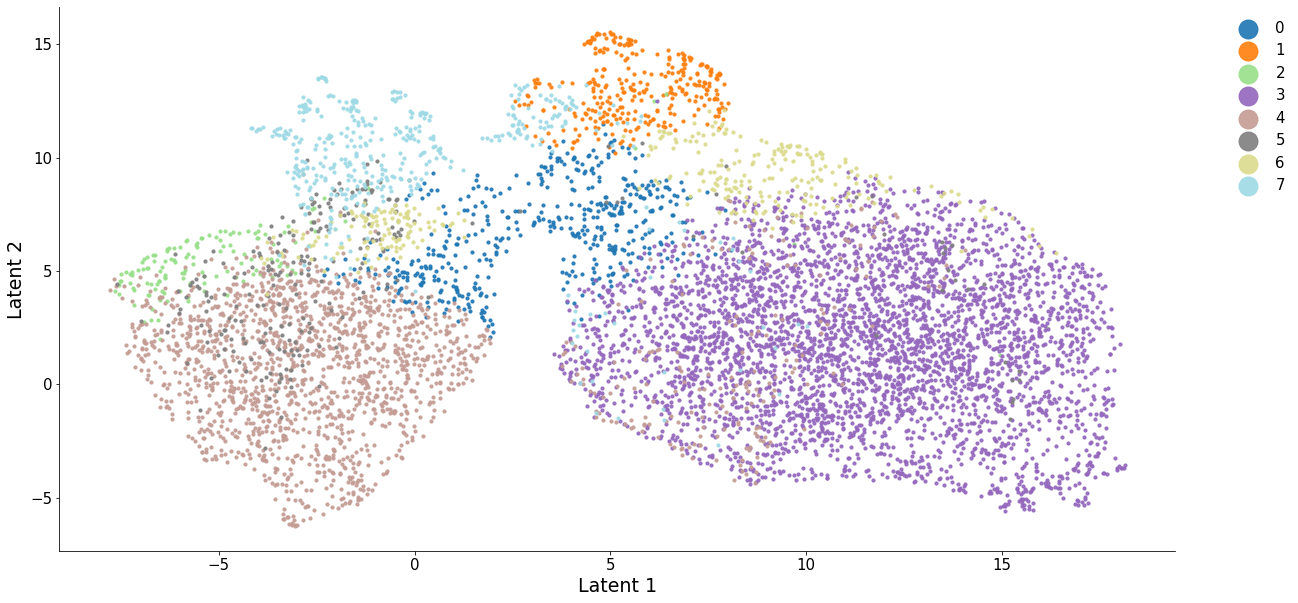

In [58]:
# scDART flavor

zs = []
labels = []
prec_labels = []
pre_labels = []
for batch in range(2):
    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cell_type"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

    
zs2 = utils.match_embeds(zs, k = 10, reference = 1, bandwidth = 40)

x_umap = umap_op.fit_transform(np.concatenate(zs2, axis = 0))
# separate into batches
x_umaps = []
for batch in range(2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 1:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent")


utils.plot_latent_ext(x_umaps, annos = pre_labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)


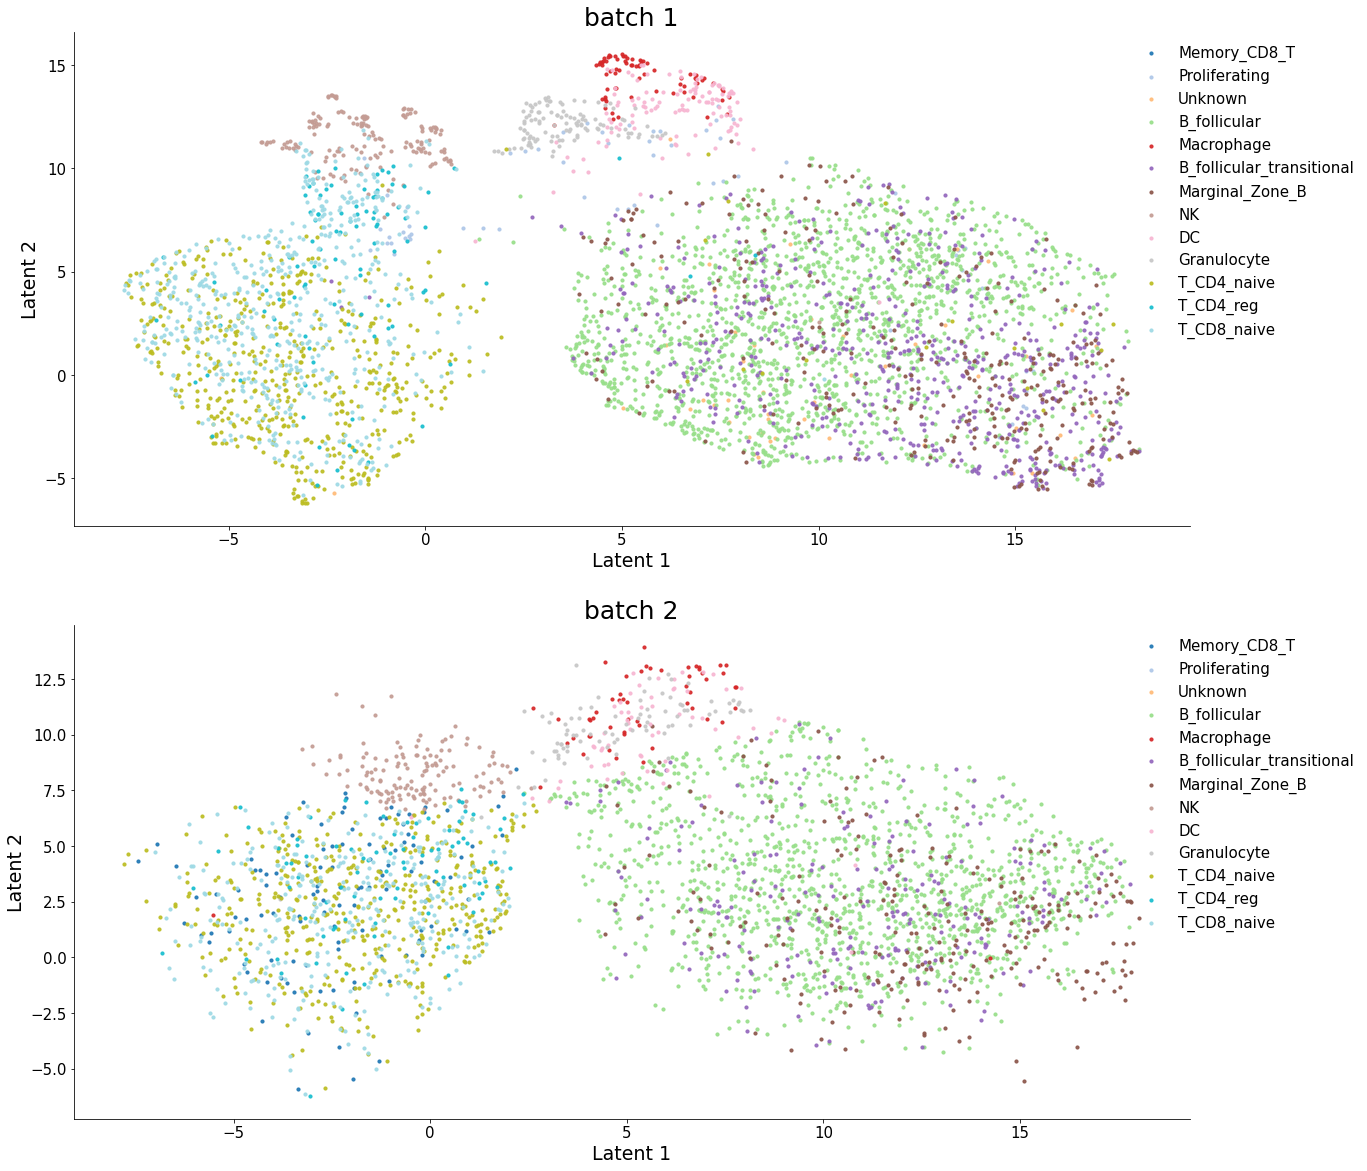

In [59]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, 
                      figsize = (20,20), axis_label = "Latent")

In [62]:
# read in dataset
dir = '../data/real/diag/Xichen/'

counts_rnas = []
counts_atacs = []
counts_proteins = []
for batch in [1, 2]:
    try:
        counts_atac = np.array(sp.load_npz(os.path.join(dir, 'RxC' + str(batch) + ".npz")).todense().T)
        counts_atac = utils.preprocess(counts_atac, modality = "ATAC")

    except:
        counts_atac = None
        
    try:
        counts_rna = np.array(sp.load_npz(os.path.join(dir, 'GxC' + str(batch) + ".npz")).todense().T)
        counts_rna = utils.preprocess(counts_rna, modality = "RNA")
    
    except:
        counts_rna = None
    
    # preprocess the count matrix
    counts_rnas.append(counts_rna)
    counts_atacs.append(counts_atac)

counts = {"rna":counts_rnas, "atac": counts_atacs}

A = sp.load_npz(os.path.join(dir, 'GxR.npz'))
A = np.array(A.todense())
interacts = {"rna_atac": A}


# obtain the feature name
genes = pd.read_csv(dir + "genes.txt", header = None).values.squeeze()
regions = pd.read_csv(dir + "regions.txt", header = None).values.squeeze()

feats_name = {"rna": genes, "atac": regions}
counts["feats_name"] = feats_name

#hyper parameters: best lr = 5e-3, T = 4000, latent_dims = 13
alpha = [1000, 1, 100, 100, 0.00]
batchsize = 0.1
run = 0
Ns = [8] * 2
K = 8
N_feat = Ns[0]
interval = 100
T = 4000
lr = 1e-2

# didn't use the interaction matrix
model1 = model.cfrm_new2(counts = counts, interacts = interacts, Ns = Ns, K = K, N_feat = N_feat, batch_size = batchsize, interval = interval, lr = lr, alpha = alpha, seed = run).to(device)
losses1 = model1.train_func(T = T, T1 = None)

Input sanity check...
Finished.
Epoch 100, Validating Loss: -173.5765
	 loss 1: 88.98426
	 loss 2: 0.00000
	 loss 3: -199.99986
	 loss 4: -62.56091
	 loss 5: 0.00000
Epoch 200, Validating Loss: -174.4239
	 loss 1: 88.96404
	 loss 2: 0.00000
	 loss 3: -199.99986
	 loss 4: -63.38805
	 loss 5: 0.00000
Epoch 300, Validating Loss: -176.4042
	 loss 1: 88.53351
	 loss 2: 0.00000
	 loss 3: -199.99901
	 loss 4: -64.93874
	 loss 5: 0.00000
Epoch 400, Validating Loss: -180.9676
	 loss 1: 86.26454
	 loss 2: 0.00000
	 loss 3: -199.99893
	 loss 4: -67.23324
	 loss 5: 0.00000


In [ ]:
# assigning cell clusters and gene clusters
model1.assign_clusters(n_relocate = None)


In [ ]:
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.8, random_state = 0) 
zs = []
labels = []
prec_labels = []
pre_labels = []
for batch in range(0,2):
    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
    # z = model1.C_cells[batch].cpu().detach().numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cell_type"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps = []
for batch in range(0,2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 1:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

In [ ]:
# utils.plot_latent_ext(x_umaps, annos = prec_labels, mode = "separate", save = None, figsize = (10,30), axis_label = "Latent")
utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, figsize = (10,15), axis_label = "Latent")
